<a href="https://colab.research.google.com/github/mariana-g-z/prolog/blob/main/Genetic_Algorithm_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install deap matplotlib numpy pandas


**Preparar el entorno en Google Colab: Esta parte importa las librerías random para generar poblaciones aleatorias y matplotlib.pyplot para visualizar la evolución del algoritmo genético.**

In [12]:
# Importar las librerías necesarias
import random
import numpy as np
import matplotlib.pyplot as plt


**Definir los nodos y sus capacidades: Aquí se representan los 5 nodos del sistema distribuido, aplicando las restricciones de uso máximo para CPU (80%), memoria (90%) y ancho de banda (75%).**

In [13]:
# Definir la capacidad de cada nodo
nodes = [
    {"cpu": 8 * 0.8, "mem": 16 * 0.9, "bw": 100 * 0.75},  # Node 1
    {"cpu": 4 * 0.8, "mem": 32 * 0.9, "bw": 50 * 0.75},   # Node 2
    {"cpu": 16 * 0.8, "mem": 8 * 0.9, "bw": 200 * 0.75},  # Node 3
    {"cpu": 12 * 0.8, "mem": 24 * 0.9, "bw": 150 * 0.75}, # Node 4
    {"cpu": 6 * 0.8, "mem": 12 * 0.9, "bw": 80 * 0.75},   # Node 5
]


**Definir las tareas y sus requisitos: Se crean 10 tareas con sus respectivos requerimientos de CPU, memoria, ancho de banda y tiempos de ejecución en cada uno de los 5 nodos.**

In [14]:
# Cada tarea tiene requerimientos y tiempos estimados por nodo
tasks = [
    {"id": 1, "cpu": 2, "mem": 4, "bw": 30, "times": [10, 15, 12, 9, 14]},
    {"id": 2, "cpu": 4, "mem": 8, "bw": 20, "times": [12, 20, 18, 14, 16]},
    {"id": 3, "cpu": 1, "mem": 2, "bw": 10, "times": [8, 10, 7, 6, 9]},
    {"id": 4, "cpu": 3, "mem": 6, "bw": 25, "times": [11, 14, 13, 10, 12]},
    {"id": 5, "cpu": 2, "mem": 3, "bw": 15, "times": [9, 12, 10, 8, 11]},
    {"id": 6, "cpu": 5, "mem": 7, "bw": 35, "times": [15, 22, 20, 18, 19]},
    {"id": 7, "cpu": 2, "mem": 4, "bw": 30, "times": [10, 14, 11, 9, 13]},
    {"id": 8, "cpu": 3, "mem": 6, "bw": 20, "times": [12, 18, 16, 13, 15]},
    {"id": 9, "cpu": 4, "mem": 5, "bw": 25, "times": [11, 17, 15, 12, 14]},
    {"id": 10,"cpu": 1, "mem": 2, "bw": 10, "times": [7, 9, 6, 5, 8]},
]


**Verificar validez de una asignación: Función para validar si una asignación de tareas a nodos cumple con las restricciones de recursos.**

In [15]:
def is_valid(individual):
    usage = [{"cpu": 0, "mem": 0, "bw": 0} for _ in nodes]
    for task_idx, node_idx in enumerate(individual):
        task = tasks[task_idx]
        remaining = {
            "cpu": nodes[node_idx]["cpu"] - usage[node_idx]["cpu"],
            "mem": nodes[node_idx]["mem"] - usage[node_idx]["mem"],
            "bw": nodes[node_idx]["bw"] - usage[node_idx]["bw"]
        }
        if not (task["cpu"] <= remaining["cpu"] and
                task["mem"] <= remaining["mem"] and
                task["bw"] <= remaining["bw"]):
            return False
        usage[node_idx]["cpu"] += task["cpu"]
        usage[node_idx]["mem"] += task["mem"]
        usage[node_idx]["bw"] += task["bw"]
    return True

**Calcular el makespan: Calcula el tiempo total de ejecución (makespan) de todas las tareas en los nodos.**

In [16]:
def calculate_makespan(individual):
    node_times = [0] * len(nodes)
    for task_idx, node_idx in enumerate(individual):
        node_times[node_idx] += tasks[task_idx]["times"][node_idx]
    return max(node_times)


**Evaluar la función de fitness: Combina makespan (prioridad principal) y utilización de recursos (secundaria). Penaliza soluciones inválidas.**

In [17]:
def evaluate_fitness(individual):
    if not is_valid(individual):
        return float('inf')  # Penalizar individuos inválidos

    makespan = calculate_makespan(individual)

    # Utilización promedio de recursos
    usage = [{"cpu": 0, "mem": 0, "bw": 0} for _ in nodes]
    for task_idx, node_idx in enumerate(individual):
        task = tasks[task_idx]
        usage[node_idx]["cpu"] += task["cpu"]
        usage[node_idx]["mem"] += task["mem"]
        usage[node_idx]["bw"] += task["bw"]

    avg_utilization = (
        sum(u["cpu"] / nodes[i]["cpu"] for i, u in enumerate(usage)) +
        sum(u["mem"] / nodes[i]["mem"] for i, u in enumerate(usage)) +
        sum(u["bw"] / nodes[i]["bw"] for i, u in enumerate(usage))
    ) / (3 * len(nodes))

    # Penalizar explícitamente sobrecarga de recursos
    penalty = 0
    for i, u in enumerate(usage):
        if u["cpu"] > nodes[i]["cpu"]:
            penalty += 100 * (u["cpu"] - nodes[i]["cpu"])
        if u["mem"] > nodes[i]["mem"]:
            penalty += 100 * (u["mem"] - nodes[i]["mem"])
        if u["bw"] > nodes[i]["bw"]:
            penalty += 100 * (u["bw"] - nodes[i]["bw"])

    # Nuevo cálculo del fitness
    fitness_value = 1.0 / (makespan + penalty + 1) + 0.3 * avg_utilization

    return fitness_value

**Generar individuos válidos: Crea una asignación inicial de tareas a nodos que cumpla con las restricciones.**

In [18]:
def generate_individual():
    max_attempts = 1000
    for _ in range(max_attempts):
        individual = []
        usage = [{"cpu": 0, "mem": 0, "bw": 0} for _ in nodes]
        valid = True

        for task in tasks:
            available_nodes = []
            for idx in range(len(nodes)):
                remaining = {
                    "cpu": nodes[idx]["cpu"] - usage[idx]["cpu"],
                    "mem": nodes[idx]["mem"] - usage[idx]["mem"],
                    "bw": nodes[idx]["bw"] - usage[idx]["bw"]
                }
                if (task["cpu"] <= remaining["cpu"] and
                    task["mem"] <= remaining["mem"] and
                    task["bw"] <= remaining["bw"]):
                    available_nodes.append(idx)

            if not available_nodes:
                valid = False
                break

            # Asignar aleatoriamente entre nodos disponibles
            selected_node = random.choice(available_nodes)
            individual.append(selected_node)
            usage[selected_node]["cpu"] += task["cpu"]
            usage[selected_node]["mem"] += task["mem"]
            usage[selected_node]["bw"] += task["bw"]

        if valid:
            return individual

    # Si falla, generar aleatorio pero asegurarse de que sea válido
    while True:
        individual = [random.randint(0, len(nodes)-1) for _ in tasks]
        if is_valid(individual):
            return individual

**Selección por torneo: Selecciona individuos basados en su fitness mediante un torneo.**

In [19]:
def tournament_selection(population, fitnesses, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        candidates = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = min(candidates, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

**Operador de cruce: Combina dos padres para crear hijos, reparando soluciones inválidas.**

In [20]:
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1)-1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]

    # Reparar hijos inválidos
    if not is_valid(child1):
        child1 = generate_individual()
    if not is_valid(child2):
        child2 = generate_individual()

    return child1, child2


**Operador de mutación: Cambia aleatoriamente la asignación de una tarea a otro nodo válido.**

In [21]:
def mutate(individual, mutation_rate=0.5):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            task = tasks[i]
            current_node = individual[i]
            available_nodes = [n for n in range(len(nodes))
                              if n != current_node and
                              task["cpu"] <= nodes[n]["cpu"] -
                              (sum(tasks[t]["cpu"] for t, node in enumerate(individual)
                                   if node == n and t != i) or 0) and
                              task["mem"] <= nodes[n]["mem"] -
                              (sum(tasks[t]["mem"] for t, node in enumerate(individual)
                                   if node == n and t != i) or 0) and
                              task["bw"] <= nodes[n]["bw"] -
                              (sum(tasks[t]["bw"] for t, node in enumerate(individual)
                                   if node == n and t != i) or 0)]
            if available_nodes:
                individual[i] = random.choice(available_nodes)
    return individual


**Algoritmo genético completo: Ejecuta el ciclo evolutivo hasta alcanzar la solución óptima.**

In [22]:
def genetic_algorithm(pop_size=100, generations=200, mutation_rate=0.2, restart_threshold=20):
    population = [generate_individual() for _ in range(pop_size)]
    best_fitness = float('inf')
    best_individual = None

    # Almacenar el historial de fitness
    fitness_history = []
    stagnation_count = 0

    for gen in range(generations):
        fitnesses = [evaluate_fitness(ind) for ind in population]

        # Actualizar mejor solución
        current_best = min(fitnesses)
        if current_best < best_fitness:
            best_fitness = current_best
            best_individual = population[np.argmin(fitnesses)]
            stagnation_count = 0  # Reiniciar contador de estancamiento
        else:
            stagnation_count += 1

        # Guardar el mejor fitness de esta generación
        fitness_history.append(best_fitness)

        # Mostrar progreso
        if gen % 10 == 0:
            print(f"Generación {gen}: Mejor fitness = {best_fitness:.4f}")

        # Reiniciar población si hay estancamiento
        #if stagnation_count >= restart_threshold:
         #   print(f"Reiniciando población en generación {gen}...")
          #  population = [generate_individual() for _ in range(pop_size)]
           # stagnation_count = 0

        # ELITISMO: Conservar el mejor individuo
        next_population = [best_individual]

        # Selección, cruce y mutación
        selected = tournament_selection(population, fitnesses)
        children = []
        for i in range(0, pop_size-1, 2):  # Deja espacio para el elitismo
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            children.extend([child1, child2])
        next_population.extend([mutate(child, mutation_rate) for child in children])

        population = next_population

    return best_individual, best_fitness, fitness_history


Generación 0: Mejor fitness = 0.2246, Makespan = 41
Generación 10: Mejor fitness = 0.2222, Makespan = 42
Generación 20: Mejor fitness = 0.2222, Makespan = 42
Reiniciando población en generación 25...
Generación 30: Mejor fitness = 0.2222, Makespan = 39
Generación 40: Mejor fitness = 0.2222, Makespan = 39
Reiniciando población en generación 46...
Generación 50: Mejor fitness = 0.2222, Makespan = 39
Generación 60: Mejor fitness = 0.2222, Makespan = 39
Reiniciando población en generación 66...
Generación 70: Mejor fitness = 0.2222, Makespan = 39
Generación 80: Mejor fitness = 0.2222, Makespan = 39
Reiniciando población en generación 86...
Generación 90: Mejor fitness = 0.2222, Makespan = 39
Generación 100: Mejor fitness = 0.2222, Makespan = 39
Reiniciando población en generación 106...
Generación 110: Mejor fitness = 0.2222, Makespan = 39
Generación 120: Mejor fitness = 0.2222, Makespan = 39
Reiniciando población en generación 126...
Generación 130: Mejor fitness = 0.2222, Makespan = 39
G

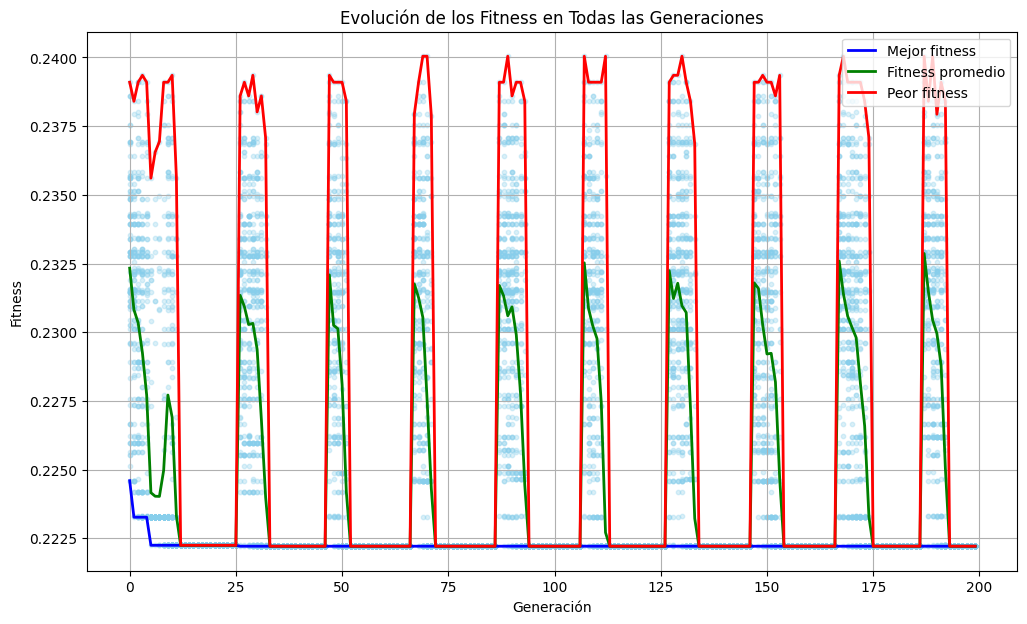


Mejor solución encontrada:
Tarea 1 → Nodo 4
Tarea 2 → Nodo 1
Tarea 3 → Nodo 4
Tarea 4 → Nodo 4
Tarea 5 → Nodo 1
Tarea 6 → Nodo 3
Tarea 7 → Nodo 4
Tarea 8 → Nodo 2
Tarea 9 → Nodo 5
Tarea 10 → Nodo 4

Makespan: 39 segundos
Fitness: 0.22221064814814812


In [24]:
# Primero, definamos una función para evaluar el fitness de toda la población
def evaluate_population(population):
    return [evaluate_fitness(ind) for ind in population]

# Modificamos la función genetic_algorithm para que guarde información de toda la población
def genetic_algorithm(pop_size=50, generations=100, mutation_rate=0.1):
    population = [generate_individual() for _ in range(pop_size)]
    best_fitness = float('inf')
    best_individual = None
    fitness_history = []  # Para almacenar el mejor fitness de cada generación
    all_population_fitness = []  # Para almacenar todos los fitness de cada generación

    for gen in range(generations):
        fitnesses = evaluate_population(population)
        all_population_fitness.append(fitnesses)  # Guardamos todos los fitness

        # Actualizar mejor solución
        current_best = min(fitnesses)
        if current_best < best_fitness:
            best_fitness = current_best
            best_individual = population[np.argmin(fitnesses)]
            stagnation_count = 0  # Reiniciar contador de estancamiento
        else:
            stagnation_count += 1

        fitness_history.append(best_fitness)  # Guardar el mejor fitness

        # Mostrar progreso
        if gen % 10 == 0:
            makespan = calculate_makespan(best_individual) if best_individual else "N/A"
            print(f"Generación {gen}: Mejor fitness = {best_fitness:.4f}, Makespan = {makespan}")

        # Reiniciar población si hay estancamiento
        if stagnation_count >= 20:
            print(f"Reiniciando población en generación {gen}...")
            population = [generate_individual() for _ in range(pop_size)]
            stagnation_count = 0
            continue  # Saltar al siguiente ciclo

        # ELITISMO: Conservar el mejor individuo
        next_population = [best_individual] if best_individual else []

        # Selección, cruce y mutación
        selected = tournament_selection(population, fitnesses)
        children = []
        for i in range(0, len(selected)-1, 2):
            if i+1 >= len(selected):
                break
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            children.extend([child1, child2])

        next_population.extend([mutate(child, mutation_rate) for child in children])
        population = next_population[:pop_size]  # Asegurar tamaño correcto

    return best_individual, best_fitness, fitness_history, all_population_fitness

# Ejecutar algoritmo
best_solution, best_fitness, fitness_history, all_population_fitness = genetic_algorithm(pop_size=100, generations=200)

# Preparar datos para el gráfico
generations = range(len(fitness_history))
avg_fitness = [np.mean(f) for f in all_population_fitness]
min_fitness = fitness_history  # Ya tenemos el mejor fitness de cada generación
max_fitness = [np.max(f) for f in all_population_fitness]

# Graficar la evolución de todos los fitness
plt.figure(figsize=(12, 7))

# Gráfico de dispersión para todos los individuos
for gen in generations:
    plt.scatter([gen]*len(all_population_fitness[gen]), all_population_fitness[gen],
                color='skyblue', alpha=0.3, s=10)

# Líneas para el mejor, peor y promedio
plt.plot(generations, min_fitness, 'b-', linewidth=2, label='Mejor fitness')
plt.plot(generations, avg_fitness, 'g-', linewidth=2, label='Fitness promedio')
plt.plot(generations, max_fitness, 'r-', linewidth=2, label='Peor fitness')

plt.title('Evolución de los Fitness en Todas las Generaciones')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

# Resultados
print("\nMejor solución encontrada:")
for task_idx, node_idx in enumerate(best_solution):
    print(f"Tarea {tasks[task_idx]['id']} → Nodo {node_idx+1}")

print(f"\nMakespan: {calculate_makespan(best_solution)} segundos")
print(f"Fitness: {best_fitness}")